<a href="https://colab.research.google.com/github/fbadine/short-ml-tutorials/blob/main/01_Initialisation_and_Activation_(Part_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation and Activation (Part 1)

**Author:** [Fadi Badine](https://twitter.com/fadibadine)<br>
**Date created:** 30/12/2021<br>
**Last modified:** 04/01/2022<br>
**Description:** This is the first of a series of small notebooks that aim to explain some of the basic neural networks concepts and best practises.

In this notebook, we will simply look at kernel initialisation, activation functions and how this can affect training convergence and gradients' vanishing.


# Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras

from functools import partial

import matplotlib.pyplot as plt

# Introduction

## Gradient Vanishing

In  early ages of deep learning, neural network layers' weights were initialised using a normal distribution with a mean μ = 0 and a standard deviation σ = 1.  
This, along with using `sigmoid`  as an activaation function ($sigmoid(z) = \frac{1}{1 + e^{-z}}$), caused deep neural networks to suffer from what we call **gradient vanishing**.

Gradient vanishing is when gradients get smaller and smaller as the gradient descent algorithm propagates down to the lower layers leaving the weights of those layers practically unchanged.

Run the below to see how `sigmoid` activation function looks like. Code taken from [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow - Chapter 11](https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb) by Aurélien Geron

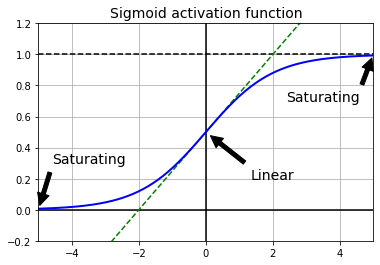

In [2]:
#@title Sigmoid Activation Function 
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, 1 / (1 + np.exp(-z)), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Glorot & Bengio Research

In 2010, Xavier Glorot and Yoshua Bengio pointed out in a paper entitled [Understanding the difficulty of training deep feedforward neural networks
](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) that for a signal to propagate properly in both directions without vanishing or exploding, we need to have the variance of the outputs of each layer to be equal to the variance of the input and for the gradients to have equal variance before and after each layer.

Since this cannot be guarranteed unless each layer has an equal number of inputs $fan_{in}$ and neurons $fan_{out}$, Glorot and Bengio proposed instead to initialise weights randomly using the following:


*   Mean μ = 0
*   Variance $ σ^2 = \frac{1}{fan_{avg}} = \frac{1}{\frac{fan_{in} + fan_{out}}{2}} = \frac{2}{fan_{in} + fan_{out}}$


## Nair & Hinton 

In 2010 as well Vinod Nair & Geoffrey Hinton proposed a new non-saturating activation function $ReLU(z) = max(0, z)$ that will become the widely used activation function.

ReLU (Rectified Linear Unit) is equal to the input when the input is positive and zero otherwise.

Having this non-saturating activation function will remove the constraint that we had with sigmoid where for large input values, the gradient is 0. In the case of ReLU, the gradient is always 1 for any positive input.

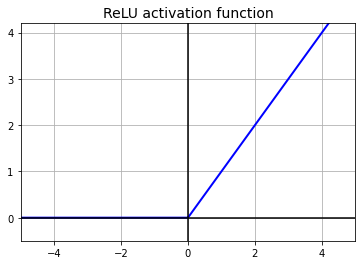

In [3]:
#@title ReLU Activation Function
z = np.linspace(-5, 5, 200)

plt.plot(z, np.maximum(0, z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.title("ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

Let's now try to visualise the improvement that Glorot kernel initialisation along with ReLU activation function do.

We will use the MNIST dataset.

# Configuration

In [4]:
#@title Parameters
BATCH_SIZE =  128 #@param {type:"slider", min:32, max:1024, step:32}
EPOCHS = 30 #@param {type:"integer"}
SEED = 1337 #@param {type:"integer"}

np.random.seed(SEED)
tf.random.set_seed(SEED)

# Data

We will use the MNIST dataset which is a collection of grayscale images of size 28x28 for digits from 0 to 9.

## Loading

In [5]:
(train_ds, valid_ds), info = tfds.load('mnist',
                                       split=['train', 'test'], 
                                       shuffle_files=True,
                                       with_info=True,
                                       as_supervised=True
                                       )

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Datase Info

In [6]:
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



The dataset contains 70,000 samples (60,000 for training and 10,000 for validation)

Each sample is a grayscale image of dimension 28x28 hence an input feature of shape (28, 28, 1)

Let's display some samples and then move to data preprocessing

## Samples Display

Let's display some dataset samples.
With tensorflow_datasets, this is as simple as calling `show_examples`

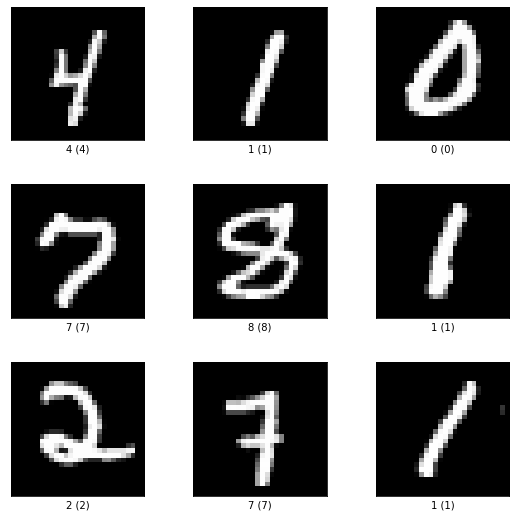

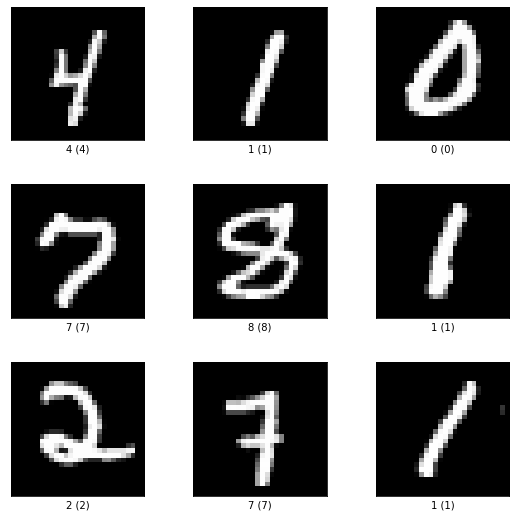

In [7]:
tfds.show_examples(train_ds, info)

## Preprocessing

In [8]:
def normalise_image(image, label):
    return tf.cast(image, tf.float32) / 255., label

def preprocess_ds(ds, batchsize = 64):
    # Normalise input features dividing them by 255. since the images are grayscale 
    ds = ds.map(normalise_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Cache features for faster retrieval
    ds = ds.cache()

    # Create batches
    ds = ds.batch(batchsize)
    
    # Call prefetch which allows subsequent elements to be prepared while the current
    # elements are being processed
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [9]:
train_ds = preprocess_ds(train_ds, BATCH_SIZE)
valid_ds = preprocess_ds(valid_ds, BATCH_SIZE)

#Model

In order to be able to visualise gradients, we will use low-level training loops instead of high-level model.fit

Let's start by creating a deep neural network

## Model Definition

In [10]:
# This is a function that we will later call to create a model using Keras' Functional API
# It takes 2 arguments:
# - The hidden layer that we will be used with the following predefined parameters:
#   * kernel_initializer
#   * activation
# - A list containing the units of the hidden dense layers.
#   The number of elements in the list is the number of hidden layers

def build_model(hidden_dense_func, hidden_layers_units):
    inputs = keras.layers.Input(shape=(28, 28, 1), name='input')

    # Transform inputs from (?, 28, 28, 1) to (?, 784)
    x = keras.layers.Flatten(name='flatten')(inputs)

    # This is a list of hidden layers units. Example [512, 256, 128]
    for i, unit in enumerate(hidden_layers_units):
        x = hidden_dense_func(unit, name='dense_' + str(i+1))(x)
    
    outputs = keras.layers.Dense(10, activation="softmax",
                                 kernel_initializer=keras.initializers.GlorotNormal(seed=SEED),
                                 name='output')(x)

    return keras.Model(inputs, outputs)

## Optimiser, loss & metrics

In [11]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=7e-4)

# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Instantiate a training accuracy metric
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Instantiate a validation accuracy metric
valid_acc_metric = keras.metrics.SparseCategoricalAccuracy()

## Training Functions

The below function will be called once in each epoch (at the first batch) and will append the gradients to a gradients history list

In [12]:
def record_epoch_gradients(grads, trainable_vars, grads_history):
    # Record the gradients with regard to all trainable variables
    # This is saved into a dictionary where the key is the variable name.
    # epoch_grads = {
    #       'dense_1': gradient_tensor,
    #       'dense_2': gradient_tensor,
    #           .
    #           .
    #       'dense_n': gradient_tensor
    # }
    epoch_grads = {}

    for grad, var in zip(grads, trainable_vars):
        # First condition in order not to take the bias
        # Second condition in order not to take the output
        # which is not sigmoid but a softmax
        if '/kernel' not in var.name or 'output' in var.name:
            continue
        name = var.name.split('/')[0]
        epoch_grads[name] = grad
    
    # Append it to the list of gradients' history
    grads_history.append(epoch_grads)
    
    return grads_history

Below are the training and validation (or test) steps that will be called in the training loop

In [13]:
@tf.function
def train_step(X, y, model):
    with tf.GradientTape() as tape:
        # Forward pass
        logits = model(X, training=True)
        # Calculate the loss
        loss_value = loss_fn(y, logits)
    
    # Calculate the gradient of the loss with respect to the trainable weights
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Update weights
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Update metrics
    train_acc_metric.update_state(y, logits)

    return loss_value, grads

@tf.function
def test_step(X, y, model):
    # Forward pass
    val_logits = model(X, training=False)

    # Calculate the loss
    loss_value = loss_fn(y, val_logits)

    # Update metrics
    valid_acc_metric.update_state(y, val_logits)
    
    return loss_value

This is the main function that will be called in order to create and train a model.  
It will take the following arguments:


*   The dense hidden layer wrapper
*   A list of hidden layers units. The number of the list's items correspond to the number of the hidden layers.



In [14]:
def create_and_train_model(hidden_dense_func, hidden_layers_units):
    # Clear session in case we are training multiple models 
    keras.backend.clear_session()

    # Create the model
    model = build_model(hidden_dense_func, hidden_layers_units)

    # Initialise a dictionary to hold the training loss and metrics
    history = {
        'loss': [],
        'acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # Initialise a list that will be filled with the gradients
    # Each item of this list contains a dictionary of all 
    # gradients with regard to all trainable variables
    grads_history = []

    for epoch in range(1, EPOCHS + 1):
        # Get batch
        for step, (X_batch_train, y_batch_train) in enumerate(train_ds):
            # Run the training step and get the training loss and the gradients
            train_loss, grads = train_step(X_batch_train, y_batch_train, model)

            if step == 0:
                # Record the gradients for this batch
                grads_history = record_epoch_gradients(grads, model.trainable_variables, grads_history)

        train_acc = train_acc_metric.result()
        train_acc_metric.reset_states()

        # Validation 
        for X_batch_valid, y_batch_valid in valid_ds:
            valid_loss = test_step(X_batch_valid, y_batch_valid, model)
        
        valid_acc = valid_acc_metric.result()
        valid_acc_metric.reset_states()

        # Print training & validation loss and accuracy
        print(f"Epoch: {epoch}/{EPOCHS} ==> loss: {train_loss:.4f}, acc: {train_acc:.4f}, val_loss: {valid_loss:.4f}, val_acc: {valid_acc:.4f}")
        
        # Update training and validation history
        history['loss'].append(train_loss)
        history['acc'].append(train_acc)
        history['val_loss'].append(valid_loss)
        history['val_acc'].append(valid_acc)
    
    return history, grads_history

## Model Training

Since we will be creating deep models, let's simplify our task by using `partial` to create a wrapper for the `Dense` layer.
This wrapper will have all the default arguments so that we won't need to rewrite them over and over.

Those dense layers will be the hidden layers for our models

In [15]:
# - Hidden dense Layer weights initialised using Normal Distribution (mean = 0 & std = 1)
# - Activation function 'sigmoid'
NormalSigmoidDense = partial(
    keras.layers.Dense,
    kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=1., seed=SEED),
    activation="sigmoid"
)

# - Hidden dense Layer weights initialised using Glorot Normal
# - Activation function 'relu'
GlorotNormalReluDense = partial(
    keras.layers.Dense,
    kernel_initializer=keras.initializers.GlorotNormal(seed=SEED),
    activation="relu"
)

In [17]:
# Titles of 2 experiments that we will do especially used in plotting results
titles = [
    'Random Normal with Sigmoid',
    'Glorot Normal with ReLU',
]

# A list that contains the partially-configured hidden layers to be used in each run
hidden_dense_func_list = [
    NormalSigmoidDense,
    GlorotNormalReluDense,
]

# The hidden layers' units
hidden_layers_units = [128, 64, 32]

In [18]:
# List to contain the loss and metrics
history_results = []

# List that will contain the gradients
grads_results = []

for title, hidden_dense_func in zip(titles, hidden_dense_func_list):
    print(f"\nTraining model with {title} ...")
    print("================================================================")

    # Create and train the model
    history, grads_history = create_and_train_model(
        hidden_dense_func,
        hidden_layers_units
    )

    # Save the training history and gradients 
    history_results.append(history)
    grads_results.append(grads_history)


Training model with Random Normal with Sigmoid ...
Epoch: 1/30 ==> loss: 2.5040, acc: 0.0654, val_loss: 2.4828, val_acc: 0.0669
Epoch: 2/30 ==> loss: 2.4094, acc: 0.0699, val_loss: 2.4306, val_acc: 0.0712
Epoch: 3/30 ==> loss: 2.3543, acc: 0.0754, val_loss: 2.4050, val_acc: 0.0765
Epoch: 4/30 ==> loss: 2.3190, acc: 0.0802, val_loss: 2.3900, val_acc: 0.0806
Epoch: 5/30 ==> loss: 2.2947, acc: 0.0837, val_loss: 2.3796, val_acc: 0.0849
Epoch: 6/30 ==> loss: 2.2766, acc: 0.0896, val_loss: 2.3711, val_acc: 0.0919
Epoch: 7/30 ==> loss: 2.2621, acc: 0.0979, val_loss: 2.3630, val_acc: 0.1011
Epoch: 8/30 ==> loss: 2.2496, acc: 0.1065, val_loss: 2.3550, val_acc: 0.1092
Epoch: 9/30 ==> loss: 2.2382, acc: 0.1137, val_loss: 2.3468, val_acc: 0.1166
Epoch: 10/30 ==> loss: 2.2276, acc: 0.1206, val_loss: 2.3386, val_acc: 0.1236
Epoch: 11/30 ==> loss: 2.2175, acc: 0.1281, val_loss: 2.3302, val_acc: 0.1296
Epoch: 12/30 ==> loss: 2.2077, acc: 0.1364, val_loss: 2.3218, val_acc: 0.1353
Epoch: 13/30 ==> loss

## Results

### Loss and Accuracy Plot

Let's first plot the loss and accuracy for both training and validation data.

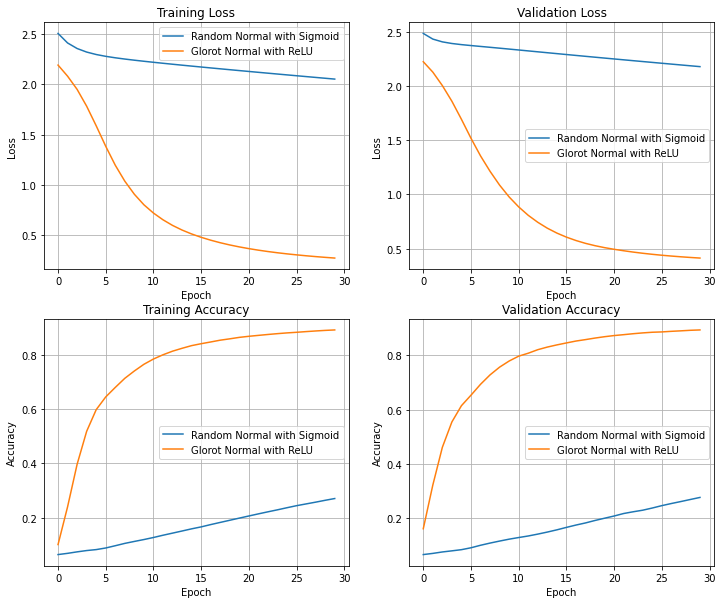

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, _ in enumerate(titles):
    axs[0,0].plot(history_results[i]['loss'])
    axs[0,1].plot(history_results[i]['val_loss'])
    axs[1,0].plot(history_results[i]['acc'])
    axs[1,1].plot(history_results[i]['val_acc'])

axs[0,0].set_title('Training Loss')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_xlabel('Epoch')
axs[0,0].legend(titles, loc='best')
axs[0,0].grid()

axs[0,1].set_title('Validation Loss')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_xlabel('Epoch')
axs[0,1].legend(titles, loc='best')
axs[0,1].grid()

axs[1,0].set_title('Training Accuracy')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_xlabel('Epoch')
axs[1,0].legend(titles, loc='best')
axs[1,0].grid()

axs[1,1].set_title('Validation Accuracy')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_xlabel('Epoch')
axs[1,1].legend(titles, loc='best')
axs[1,1].grid()

plt.show()

We obviously see that the randomly initialised model with 1 as standard deviation and sigmoid as activation function does not converge

### Gradients Plot

Let's now plot the gradients

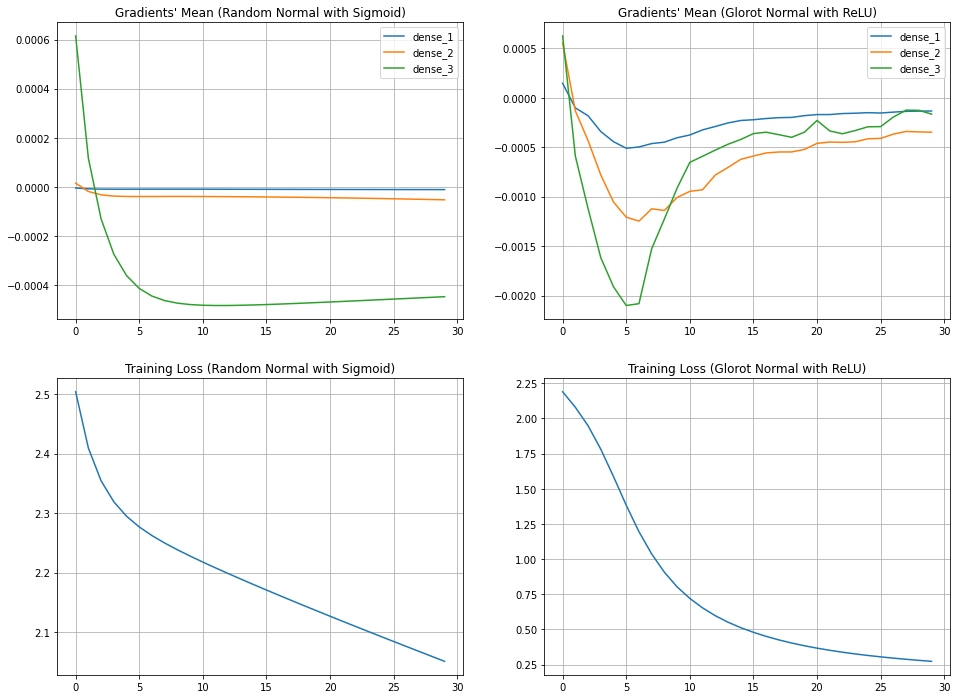

In [20]:
fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(16, 12))

for i, title in enumerate(titles):
    axs[0, i].set_title(f"Gradients' Mean ({titles[i]})")
    for key in grads_results[i][0]:
        axs[0,i].plot(range(len(grads_results[i])), [tf.reduce_mean(g[key]) for g in grads_results[i]], label=key)
    axs[0,i].legend()
    axs[0,i].grid()

    axs[1, i].plot(history_results[i]['loss'])
    axs[1, i].set_title(f"Training Loss ({titles[i]})")
    axs[1, i].grid()


plt.show()

In the case of Random Normal with sigmoid activation function, we notice the following:


*   The last hidden layer `dense_3` is the only one with significant gradient
*   The other layers have gradients that are almost zero which proves that the gradient is vanishing when we go down towards the first layers.

In the case of Glorot initialisation with ReLU, we find that the gradients are not vanishing. All gradients are tending to zero when the loss is not changing much.



# Summary

So to summarise, in this notebook, we learnt:


*   how initialisation has changed over the years
*   how activation functions has a strong impact on convergence and on reducing gradients vanishing
*   how to train a Keras model using low level training loop

In the next notebook, we will talk more about initialisation in Keras and will look at more activation functions.



# References

This notebook has been influenced and has used code found in:


*   [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow - Chapter 11](https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb) by [Aurélien Geron](https://twitter.com/aureliengeron)
*   [Writing a training loop from scratch](https://keras.io/guides/writing_a_training_loop_from_scratch/) by [François Chollet](https://twitter.com/fchollet)
*   [Visualizing the vanishing gradient problem](https://machinelearningmastery.com/visualizing-the-vanishing-gradient-problem/) by [Adrian Tam](https://machinelearningmastery.com/author/adriantam/)

